<h1 align="center" style="color:green;font-size: 3em;">Homework 2: Self-Supervised Visual Contrastive Learning with SimCLR</h1>

**Introduction:**
In this lab, we will explore the principles and practical applications of self-supervised learning. We will focus on the SimCLR approach.

**Objectives:**
- Exploring self-supervised learning

**Instructions:**
- Follow the notebook sections to implement various parts of this homework exercise.
- Code cells marked with `TODO` are parts that you need to complete.
- Ensure your code runs correctly by the end of the notebook.
- **Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu.**

In [1]:
import os
import io
from PIL import Image
from tqdm import tqdm
import torch
import torchvision
from torch import nn
import torch.utils.data
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms

import numpy as np
from matplotlib import pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"You selected as device: {device}")

You selected as device: cuda:0


# Introduction

In this lab, we will explore the principles and practical applications of self-supervised learning, first in a uni-modal setting, and then in a multimodal setting. We will focus on the SimCLR and CLIP models respectively.


### Objectives
- Exploring self-supervised learning
- Handling multimodal data  

# Self-Supervised Learning: SimCLR

## How SimCLR works?
SimCLR, short for Simple Framework for Contrastive Learning of Visual Representations, is a self-supervised learning method designed to train deep neural networks without labeled data. It enables models to learn meaningful visual representations by contrasting positive pairs (augmented views of the same image) against negatives.



<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-02_at_4.31.34_PM_7zlWDQE.png" width=300>

Figure: A simple framework for contrastive learning of visual representation [Chen et al, 2020]

In practice, SimCLR relies on:

1. Data Augmentation:
Randomly sample a minibatch $B$ of samples, and apply two different data augmentations to each sample $x$, resulting in $2N$ augmented samples:

$\tilde{x_i}=t(x), \tilde{x_j}=t'(x), t,t' \sim T$

where $t,t'$ are two separate data augmentation operators, sampled from the same family of augmentation $T$.
Data augmentation includes random crop, resize with random flip, color distortions, and Gaussian blur.

2. Given one positive pair, other
 data points are treated as negative samples. The representation is produced by a base encoder $f(.)$ (e.g. ResNet-18):

$h_i = f(\tilde{x_i}), h_j = f(\tilde{x_j})$

3. The contrastive learning loss is defined using cosine similarity $\text{sim}(.,.)$. The loss is computed on an projection layer of the representation  rather than on the representation space directly. The representation $h$ is used for downstream tasks.

$L_\text{simclr}^{(i,j)} = -\text{log} \frac{\text{exp}( \text{sim}(z_i, z_j)/ \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \text{exp}( \text{sim}(z_i, z_k)/ \tau)}$, $\mathbb{1}_{[k \neq i]}$ the indicator function, 1 if $k \neq i$ 0 otherwise.



For more details see: https://arxiv.org/pdf/2002.05709



Self-supervised learning (SSL) approaches for image understanding have demonstrated state-of-the-art performance across various settings. These methods are particularly effective when trained on large-scale datasets containing millions of images, enabling the learning of general-purpose representations. To gain a practical understanding of these methodologies, we will experiment with CIFAR-100, a smaller-scale dataset that simplifies the exploration of SSL concepts while preserving their core principles.

We will compare a fully-supervised baseline with a backbone pretrained using SimCLR, followed by fine-tuning. This comparison will highlight some benefits of self-supervised pretraining.

### Question 1.1
Train a fully-supervised baseline on CIFAR-100.

Use the ResNet-18 on CIFAR-100 for 20 epochs and log both train and test loss and accuracy.
Hparameters are to be choosen to your discretion.

Hparams:
- Use Adam with some weight decay to avoid overfitting
- Use data augmentation strategy to avoid overfitting on the training data

In [2]:
def supervised_baseline(n_epochs, batch_size, lr):
    # - transformations
    train_transform = transforms.Compose([
        transforms.autoaugment.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

    # - dataset and dataloader
    trainset = torchvision.datasets.CIFAR100(root="./data", train=True, transform=train_transform, download=True)
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True,num_workers=2)

    testset = torchvision.datasets.CIFAR100(root="./data", train=False, transform=test_transform, download=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

    # - model
    model = torchvision.models.resnet18(pretrained=False) # load the architecture
    model.fc = nn.Linear(model.fc.in_features, 100) # change the output layer to match the number of classes
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    # - training loop
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    test_losses  = []
    for epoch in range(n_epochs): # loop over the dataset multiple times
        model.train()
        epoch_loss = 0.0
        epoch_acc = 0.0
        print(f"Running epoch {epoch}")
        for _, batch in enumerate(tqdm(trainloader), 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            # TODO: complete the remaining train code here.

            # TODO 0: zero the gradients
            optimizer.zero_grad()

            # TODO 1: get the predictions and compute loss
            outputs = model(inputs.to(device))
            loss = criterion(outputs, labels.to(device))

            # TODO 2: do backward
            loss.backward()
            optimizer.step()

            # TODO 3: compute accuracy, track loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += torch.eq(torch.max(outputs, 1)[1], labels.to(device)).sum().item()


        # TODO 4: compute average train loss and accuracy
        epoch_loss /= len(trainloader)
        epoch_acc /= len(trainloader.dataset)
        epoch_acc *= 100

        # Print and track training loss and accuracy.
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_loss:.3f}, Train Acc: {epoch_acc:.3f}')
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        with torch.no_grad():
            test_acc = 0
            test_loss = 0
            for _, batch in enumerate(tqdm(testloader)):
                inputs, labels = batch[0].to(device), batch[1].to(device)
                # TODO: complete the remaining test code here.

                # TODO 1: get prediction
                outputs = model(inputs.to(device))

                # TODO 2: compute loss
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                # TODO 3: compute accuracy
                test_acc += torch.eq(torch.max(outputs, dim=1)[1], labels.to(device)).sum().item()

            # TODO 4: compute average test loss and accuracy
            test_loss /= len(testloader)
            test_acc /= len(testloader.dataset)
            test_acc *= 100

            # Print and track test loss and accuracy.
            test_accuracies.append(test_acc)
            test_losses.append(test_loss)
            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_loss:.3f}, Train Acc: {epoch_acc:.3f}, Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}')


    # Do plots
    plt.plot(train_losses, label="train loss")
    plt.plot(test_losses, label="test loss")
    plt.show()
    # - acc curves
    plt.plot(train_accuracies, label="train accuracy")
    plt.plot(test_accuracies, label="test accuracy")
    plt.show()

100%|██████████| 169M/169M [00:05<00:00, 28.2MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Running epoch 0


100%|██████████| 391/391 [00:19<00:00, 19.66it/s]


Epoch 1/20, Train Loss: 4.059, Train Acc: 9.024


100%|██████████| 79/79 [00:01<00:00, 54.73it/s]


Epoch 1/20, Train Loss: 4.059, Train Acc: 9.024, Test Loss: 3.359, Test Acc: 19.670
Running epoch 1


100%|██████████| 391/391 [00:16<00:00, 24.33it/s]


Epoch 2/20, Train Loss: 3.471, Train Acc: 18.038


100%|██████████| 79/79 [00:01<00:00, 53.55it/s]


Epoch 2/20, Train Loss: 3.471, Train Acc: 18.038, Test Loss: 2.924, Test Acc: 27.280
Running epoch 2


100%|██████████| 391/391 [00:16<00:00, 24.19it/s]


Epoch 3/20, Train Loss: 3.138, Train Acc: 24.000


100%|██████████| 79/79 [00:01<00:00, 62.03it/s]


Epoch 3/20, Train Loss: 3.138, Train Acc: 24.000, Test Loss: 2.662, Test Acc: 32.460
Running epoch 3


100%|██████████| 391/391 [00:16<00:00, 24.14it/s]


Epoch 4/20, Train Loss: 2.901, Train Acc: 28.158


100%|██████████| 79/79 [00:01<00:00, 61.21it/s]


Epoch 4/20, Train Loss: 2.901, Train Acc: 28.158, Test Loss: 2.504, Test Acc: 36.670
Running epoch 4


100%|██████████| 391/391 [00:15<00:00, 24.90it/s]


Epoch 5/20, Train Loss: 2.711, Train Acc: 32.306


100%|██████████| 79/79 [00:01<00:00, 56.22it/s]


Epoch 5/20, Train Loss: 2.711, Train Acc: 32.306, Test Loss: 2.361, Test Acc: 39.520
Running epoch 5


100%|██████████| 391/391 [00:15<00:00, 24.72it/s]


Epoch 6/20, Train Loss: 2.558, Train Acc: 35.314


100%|██████████| 79/79 [00:01<00:00, 61.48it/s]


Epoch 6/20, Train Loss: 2.558, Train Acc: 35.314, Test Loss: 2.279, Test Acc: 40.570
Running epoch 6


100%|██████████| 391/391 [00:16<00:00, 23.45it/s]


Epoch 7/20, Train Loss: 2.409, Train Acc: 38.452


100%|██████████| 79/79 [00:01<00:00, 63.44it/s]


Epoch 7/20, Train Loss: 2.409, Train Acc: 38.452, Test Loss: 2.188, Test Acc: 43.190
Running epoch 7


100%|██████████| 391/391 [00:16<00:00, 24.33it/s]


Epoch 8/20, Train Loss: 2.278, Train Acc: 41.438


100%|██████████| 79/79 [00:01<00:00, 64.48it/s]


Epoch 8/20, Train Loss: 2.278, Train Acc: 41.438, Test Loss: 2.123, Test Acc: 44.130
Running epoch 8


100%|██████████| 391/391 [00:15<00:00, 24.45it/s]


Epoch 9/20, Train Loss: 2.160, Train Acc: 43.796


100%|██████████| 79/79 [00:01<00:00, 50.59it/s]


Epoch 9/20, Train Loss: 2.160, Train Acc: 43.796, Test Loss: 2.098, Test Acc: 45.580
Running epoch 9


100%|██████████| 391/391 [00:16<00:00, 24.18it/s]


Epoch 10/20, Train Loss: 2.040, Train Acc: 46.754


100%|██████████| 79/79 [00:01<00:00, 56.23it/s]


Epoch 10/20, Train Loss: 2.040, Train Acc: 46.754, Test Loss: 2.085, Test Acc: 45.640
Running epoch 10


100%|██████████| 391/391 [00:16<00:00, 23.82it/s]


Epoch 11/20, Train Loss: 1.940, Train Acc: 48.996


100%|██████████| 79/79 [00:01<00:00, 57.40it/s]


Epoch 11/20, Train Loss: 1.940, Train Acc: 48.996, Test Loss: 2.067, Test Acc: 46.010
Running epoch 11


100%|██████████| 391/391 [00:16<00:00, 24.11it/s]


Epoch 12/20, Train Loss: 1.838, Train Acc: 51.472


100%|██████████| 79/79 [00:01<00:00, 61.82it/s]


Epoch 12/20, Train Loss: 1.838, Train Acc: 51.472, Test Loss: 2.073, Test Acc: 45.990
Running epoch 12


100%|██████████| 391/391 [00:16<00:00, 23.52it/s]


Epoch 13/20, Train Loss: 1.744, Train Acc: 54.280


100%|██████████| 79/79 [00:01<00:00, 59.66it/s]


Epoch 13/20, Train Loss: 1.744, Train Acc: 54.280, Test Loss: 2.036, Test Acc: 47.210
Running epoch 13


100%|██████████| 391/391 [00:16<00:00, 23.97it/s]


Epoch 14/20, Train Loss: 1.646, Train Acc: 56.504


100%|██████████| 79/79 [00:01<00:00, 63.63it/s]


Epoch 14/20, Train Loss: 1.646, Train Acc: 56.504, Test Loss: 2.055, Test Acc: 47.670
Running epoch 14


100%|██████████| 391/391 [00:16<00:00, 24.35it/s]


Epoch 15/20, Train Loss: 1.571, Train Acc: 58.454


100%|██████████| 79/79 [00:01<00:00, 60.74it/s]


Epoch 15/20, Train Loss: 1.571, Train Acc: 58.454, Test Loss: 2.086, Test Acc: 47.460
Running epoch 15


100%|██████████| 391/391 [00:16<00:00, 24.28it/s]


Epoch 16/20, Train Loss: 1.490, Train Acc: 60.576


100%|██████████| 79/79 [00:01<00:00, 62.61it/s]


Epoch 16/20, Train Loss: 1.490, Train Acc: 60.576, Test Loss: 2.105, Test Acc: 47.530
Running epoch 16


100%|██████████| 391/391 [00:16<00:00, 23.42it/s]


Epoch 17/20, Train Loss: 1.416, Train Acc: 62.676


100%|██████████| 79/79 [00:01<00:00, 55.62it/s]


Epoch 17/20, Train Loss: 1.416, Train Acc: 62.676, Test Loss: 2.148, Test Acc: 46.850
Running epoch 17


100%|██████████| 391/391 [00:15<00:00, 24.48it/s]


Epoch 18/20, Train Loss: 1.351, Train Acc: 64.270


100%|██████████| 79/79 [00:01<00:00, 54.63it/s]


Epoch 18/20, Train Loss: 1.351, Train Acc: 64.270, Test Loss: 2.165, Test Acc: 47.820
Running epoch 18


100%|██████████| 391/391 [00:16<00:00, 24.05it/s]


Epoch 19/20, Train Loss: 1.282, Train Acc: 66.292


100%|██████████| 79/79 [00:01<00:00, 55.41it/s]


Epoch 19/20, Train Loss: 1.282, Train Acc: 66.292, Test Loss: 2.196, Test Acc: 47.710
Running epoch 19


100%|██████████| 391/391 [00:16<00:00, 24.08it/s]


Epoch 20/20, Train Loss: 1.250, Train Acc: 67.186


100%|██████████| 79/79 [00:01<00:00, 61.16it/s]


Epoch 20/20, Train Loss: 1.250, Train Acc: 67.186, Test Loss: 2.223, Test Acc: 47.650


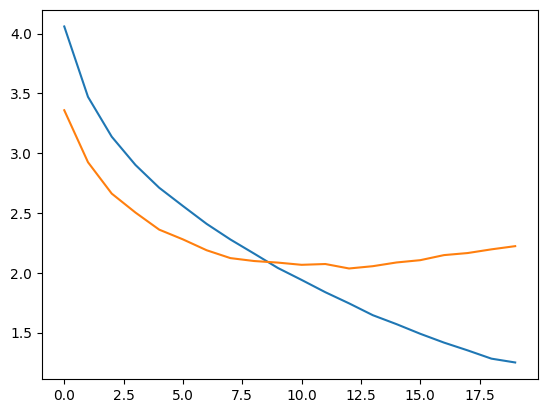

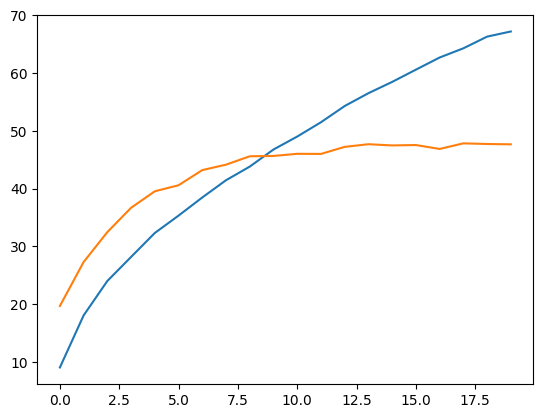

In [3]:
lr = 1e-3
batch_size = 128
n_epochs = 20
supervised_baseline(n_epochs=n_epochs, lr=lr, batch_size=batch_size)

### Question 1.2
We need to prepare the data loading such that we sample two different, random augmentations for each image in the batch. The easiest way to do this is by creating a class that, when being called, applies a set of data augmentations to an image twice. This is implemented in the class CustomTransform below.

Implement the Data Augmentation module.

In [4]:
class CustomTransform(object):
    """Custom Transform class for SimCLR"""
    def __init__(self, transform):
        """Initializes the transforms"""
        self.transforms = transform

    def __call__(self, x):
        """Applies the two transformations to the input x

        __call__ method allows an instance of a class to
        be called as if it were a function.

        Parameters
        ----------
        x: torch.Tensor
            Input image tensor to be transformed

        Returns
        -------
        x1, x2: torch.Tensor, torch.Tensor
            Transformed images
        """
        # TODO
        x1 = self.transforms(x)
        x2 = self.transforms(x)
        # return two different augmented versions
        return x1, x2

### Visualize the two augmented views on an image

Plot a few pairs of transformed images from the dataset using `CustomTransform`

Tip. CIFAR-100 is a low resolution data set, thus images may appear highly pixelized.

In [5]:
base_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(size=32),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.5,
                                contrast=0.5,
                                saturation=0.5,
                                hue=0.1)
    ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])
paired_transformed = CustomTransform(base_transform)
train_set = torchvision.datasets.CIFAR100(root="./data",
                                          train=True,
                                          transform=paired_transformed,
                                          download=True)
item = train_set[0][0]


Files already downloaded and verified


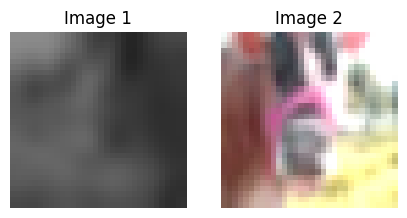

In [6]:
def  plot_images(im1, im2):
    """Plot two images side by side

    Parameters
    ----------
    im1: torch.Tensor
        First image
    im2: torch.Tensor
        Second image
    """
    # Create a figure with two subplots side by side
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 3))

    # Display the first image
    ax1.imshow(im1)
    ax1.set_title('Image 1')
    ax1.axis('off')  # Hide axes ticks

    # Display the second image
    ax2.imshow(im2)
    ax2.set_title('Image 2')
    ax2.axis('off')  # Hide axes ticks

plot_images(train_set[0][0][0].permute(1, 2, 0),
            train_set[0][0][1].permute(1, 2, 0))

### Question 1.3

To implement the SimCLR architecture, we need a model composed of:
- the backbone $f$ (e.g. ResNet-18)
- the projection head ($g$), a two layer MLP
- at each forward pass, return the represention ($h = f(x)$) and the projection ($z = g(h)$)

Implement the model.

Tip.
- Remove the last fully connected layer from ResNet-18 (which is the classifier layer when used with ImageNet), you can do this by replacing it by `nn.Identity`

In [16]:
class SimCLRModel(nn.Module):
    def __init__(self, hidden_dim=2048, projection_dim=128):
        """
        Backbone class which returns the hidden representation h and the projection z

        Parameters:
        -----------
        hidden_dim: int
            The hidden dimension of the projector. Default is 512
        projection_dim: int
            The dimension of the output features after projection. Default is 128
        """
        super(SimCLRModel, self).__init__()

        self.backbone = torchvision.models.resnet18(pretrained = False)
        # Get the input size of the last layer fc of ResNet-18
        out_features = self.backbone.fc.in_features
        # Remove the classification layer, replace it with Identity, output feature h
        self.backbone.fc = nn.Identity()
        # TODO:
        # self.projector = ... # define it as a 2-layer MLP.

        self.projector = nn.Sequential(
            nn.Linear(out_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, projection_dim)
        )




    def forward(self, x):
        """Forward pass

        Parameters:
        -----------
        x: torch.Tensor
            The input tensor

        return the output features from the projection MLP.
        """
        # TODO
        # ResNet-18 extract features h
        h = self.backbone(x)
        # Use MLP for projection
        z = self.projector(h)
        return h, z

### Question 1.4
Implement the constrastive loss as mentionned in the introduction paragraph of SimCLR.

$L_\text{simclr}^{(i,j)} = -\text{log} \frac{\text{exp}( \text{sim}(z_i, z_j)/ \tau)}{\sum_{k=1}^{2N} \mathbb{1}_{[k \neq i]} \text{exp}( \text{sim}(z_i, z_k)/ \tau)}$, $\mathbb{1}_{[k \neq i]}$ the indicator function, 1 if $k \neq i$ 0 otherwise.

Tip.
You can first compute the 2N×2N matrix (both dimensions contain all augmented views) and then deduce the numerator and denominator by extracting the positives and negatives pairs.


Illustration of the similarity matrix for a batch size \(N=2\):

| Views  | View1A | View1B | View2A | View2B |
|--------|--------|--------|--------|--------|
| View1A |   -    |   ✓    |   ✗    |   ✗    |
| View1B |   ✓    |   -    |   ✗    |   ✗    |
| View2A |   ✗    |   ✗    |   -    |   ✓    |
| View2B |   ✗    |   ✗    |   ✓    |   -    |


- The similarity matrix is (2N)×(2N) where N is your batch size (because each sample has 2 augmented views)
- Positive pairs (✓): Off-diagonal elements where View[i] A matches with View[i] B
These are different augmentations of the same original image
- Negative pairs (✗): All other off-diagonal elements
- Diagonal elements (-): Removed because they represent self-similarity


In [17]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss, also called InfoNceLoss as in SimCLR paper
    """

    def __init__(self, batch_size, temperature=0.05):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()

    def forward(self, proj_1, proj_2):
        """
        proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
        where corresponding indices are pairs
        z_i, z_j in the SimCLR paper

        returns the loss
        """

        # TODO L2-normalize the features.
        z = F.normalize(torch.cat([proj_1, proj_2], dim=0), dim = 1)

        # TODO: compute the 2N×2N matrix
        similarity_matrix = torch.matmul(z, z.T) / self.temperature

        # TODO: extract from similarity_matrix the similarities that correspond to the poitive pairs.
        batch_size = proj_1.size(0)
        pos_mask = torch.zeros_like(similarity_matrix, dtype=bool)
        indices = torch.arange(batch_size)
        pos_mask[indices, indices + batch_size] = True
        pos_mask[indices + batch_size, indices] = True

        # Positive sample extraction
        positives = similarity_matrix[pos_mask].view(2 * batch_size, 1)

        # TODO: extract from similarity_matrix the similarities that correspond to the negative pairs.
        neg_mask = ~torch.eye(2 * batch_size, dtype=bool).to(z.device)
        negatives = similarity_matrix[neg_mask & ~pos_mask].view(2 * batch_size, -1)

        # TODO: compute the loss. Tips:
        # - compute the explonentials of the positive (nominator) and negative (denominator) pairs
        # - When summing the exponentials of the denominator take care to skip the similarities that correspond to the
        #   diagonal (self-similarities)
        logits = torch.cat([positives, negatives], dim=1)
        loss = F.cross_entropy(logits, torch.zeros(2 * batch_size).long().to(z.device))

        return loss

### Question 1.5
Train the `SimCLRModel` on the CIFAR-100 dataset using the `ContrastiveLoss` for 100 epochs (for compute reason you can use only **10 epochs**) and log train losses.
Hyperparameters are to be choosen to your discretion.

Tips.
- You can use the `torch.optim.Adam` with weight decay
- You can set the temperature in `ContrastiveLoss` to 0.5

Training takes around 30min (depending of hparams).

In [20]:
def unsupervised_training(device, lr,  n_epochs, batch_size, temperature=0.05):
    """Unsupervised training using SimCLR framework

    Parameters
    ----------
    device: str
        The device to use for training
    lr: float
        The learning rate
    n_epochs: int
        The number of epochs to train for

    Returns
    -------
    model: nn.Module
        the trained model
    """
    # - Create the model
    model = SimCLRModel(hidden_dim=512, projection_dim=128).to(device)
    # - Data
    base_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=32),
        transforms.RandomApply([
            transforms.ColorJitter(brightness=0.5,
                                    contrast=0.5,
                                    saturation=0.5,
                                    hue=0.1)
        ], p=0.8),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.Resize((32, 32)),
        transforms.ToTensor()
    ])
    train_set = torchvision.datasets.CIFAR100(root="./data",
                                              train=True,
                                              transform=CustomTransform(base_transform),
                                              download=True)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

    # - optimizer and criterion
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    criterion = ContrastiveLoss(temperature=temperature, batch_size=batch_size)
    # - epochs
    losses = []
    for epoch in (pbar:=tqdm(range(n_epochs))):
        epoch_loss = 0
        model.train()

        # TODO: implement a training epoch of SimCLR
        for (x1, x2), _ in train_loader:
          x1, x2 = x1.to(device), x2.to(device)

          optimizer.zero_grad()

          # Calculate the projection features
          _, z1 = model(x1)
          _, z2 = model(x2)

          # Calculate constrasive loss
          loss = criterion(z1, z2)

          loss.backward()
          optimizer.step()

          epoch_loss += loss.item()

        # track epoch loss
        epoch_loss /= len(train_loader)
        losses.append(epoch_loss)
        print(f"[Epoch {epoch+1}/{n_epochs}]  Loss: {epoch_loss:.4f}")

    # print losses.
    plt.figure(figsize=(10, 5))
    plt.plot(losses)

    return model

Files already downloaded and verified


  3%|▎         | 1/35 [02:55<1:39:30, 175.61s/it]

[Epoch 1/35]  Loss: 5.2989


  6%|▌         | 2/35 [05:51<1:36:39, 175.74s/it]

[Epoch 2/35]  Loss: 4.7121


  9%|▊         | 3/35 [08:46<1:33:28, 175.27s/it]

[Epoch 3/35]  Loss: 4.4185


 11%|█▏        | 4/35 [11:40<1:30:25, 175.02s/it]

[Epoch 4/35]  Loss: 4.1533


 14%|█▍        | 5/35 [14:34<1:27:21, 174.72s/it]

[Epoch 5/35]  Loss: 3.9600


 17%|█▋        | 6/35 [17:29<1:24:21, 174.53s/it]

[Epoch 6/35]  Loss: 3.8295


 20%|██        | 7/35 [20:22<1:21:14, 174.11s/it]

[Epoch 7/35]  Loss: 3.6760


 23%|██▎       | 8/35 [23:16<1:18:24, 174.25s/it]

[Epoch 8/35]  Loss: 3.5807


 26%|██▌       | 9/35 [26:11<1:15:32, 174.31s/it]

[Epoch 9/35]  Loss: 3.4817


 29%|██▊       | 10/35 [29:05<1:12:36, 174.26s/it]

[Epoch 10/35]  Loss: 3.3994


 31%|███▏      | 11/35 [31:59<1:09:43, 174.31s/it]

[Epoch 11/35]  Loss: 3.3242


 34%|███▍      | 12/35 [34:54<1:06:48, 174.28s/it]

[Epoch 12/35]  Loss: 3.2494


 37%|███▋      | 13/35 [37:48<1:03:51, 174.17s/it]

[Epoch 13/35]  Loss: 3.1822


 40%|████      | 14/35 [40:43<1:01:04, 174.50s/it]

[Epoch 14/35]  Loss: 3.1199


 43%|████▎     | 15/35 [43:37<58:09, 174.48s/it]  

[Epoch 15/35]  Loss: 3.0861


 46%|████▌     | 16/35 [46:31<55:13, 174.37s/it]

[Epoch 16/35]  Loss: 2.9902


 49%|████▊     | 17/35 [49:26<52:22, 174.58s/it]

[Epoch 17/35]  Loss: 2.9611


 51%|█████▏    | 18/35 [52:22<49:32, 174.86s/it]

[Epoch 18/35]  Loss: 2.9250


 54%|█████▍    | 19/35 [55:16<46:35, 174.69s/it]

[Epoch 19/35]  Loss: 2.9071


 57%|█████▋    | 20/35 [58:10<43:37, 174.51s/it]

[Epoch 20/35]  Loss: 2.8366


 60%|██████    | 21/35 [1:01:05<40:42, 174.44s/it]

[Epoch 21/35]  Loss: 2.8114


 63%|██████▎   | 22/35 [1:04:00<37:50, 174.64s/it]

[Epoch 22/35]  Loss: 2.7864


 66%|██████▌   | 23/35 [1:06:54<34:55, 174.61s/it]

[Epoch 23/35]  Loss: 2.7554


 69%|██████▊   | 24/35 [1:09:50<32:05, 175.02s/it]

[Epoch 24/35]  Loss: 2.7024


 71%|███████▏  | 25/35 [1:12:45<29:09, 174.97s/it]

[Epoch 25/35]  Loss: 2.6648


 74%|███████▍  | 26/35 [1:15:41<26:16, 175.13s/it]

[Epoch 26/35]  Loss: 2.6363


 77%|███████▋  | 27/35 [1:18:36<23:21, 175.25s/it]

[Epoch 27/35]  Loss: 2.6326


 80%|████████  | 28/35 [1:21:31<20:24, 175.00s/it]

[Epoch 28/35]  Loss: 2.5900


 83%|████████▎ | 29/35 [1:24:25<17:29, 174.86s/it]

[Epoch 29/35]  Loss: 2.5592


 86%|████████▌ | 30/35 [1:27:19<14:33, 174.68s/it]

[Epoch 30/35]  Loss: 2.5393


 89%|████████▊ | 31/35 [1:30:13<11:37, 174.45s/it]

[Epoch 31/35]  Loss: 2.5114


 91%|█████████▏| 32/35 [1:33:07<08:42, 174.33s/it]

[Epoch 32/35]  Loss: 2.4942


 94%|█████████▍| 33/35 [1:36:00<05:47, 173.99s/it]

[Epoch 33/35]  Loss: 2.4853


 97%|█████████▋| 34/35 [1:38:53<02:53, 173.58s/it]

[Epoch 34/35]  Loss: 2.4258


100%|██████████| 35/35 [1:41:47<00:00, 174.49s/it]

[Epoch 35/35]  Loss: 2.4269


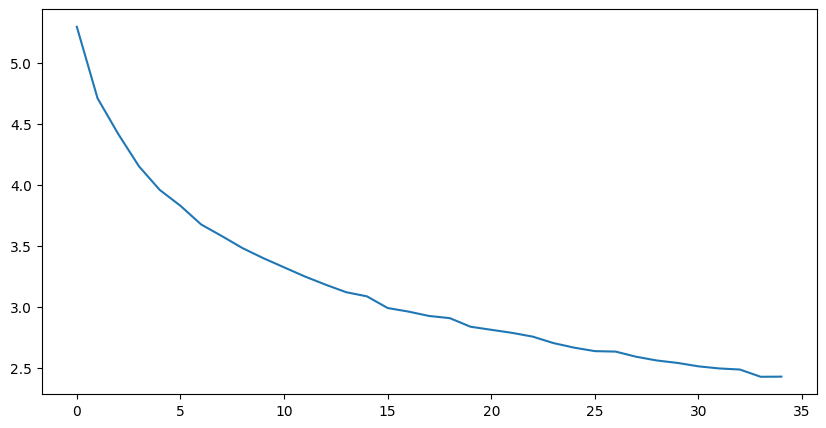

In [ ]:
batch_size = 256 # Hparam to complete. You can try other values. The bigger the better.
lr = 3e-4 # Hparam to complete. You can try other values.
n_epochs = 35 # Hparam to complete. You can try other values. The bigger the better.

simclr_model = unsupervised_training(device=device, lr=lr, n_epochs=n_epochs, batch_size=batch_size)

In [23]:
# Store Model
torch.save(simclr_model, "simclr_model_complete.pth")
print("Model saved successfully!")

Model saved successfully!


### Question 1.6

Now that the model has been pretrained, let's finetune it on the downstream task: classification.

Add a linear classifier on top of the representation and train all (both the backbone from the SimCLR model: the Resnet-18 pretrained and the linear classifier) on CIFAR-100 for 20 epochs using `CrossEntropyLoss`  and log both train and test loss and accuracies.
The model should converge faster than when trained in a full-supervised way, and achieve a better accuracy.

Hparameters are to be choosen to your discretion.

In [28]:
def supervised_training(simclr_model,
                   n_classes,
                   n_epochs,
                   lr,
                   device,
                   batch_size):

    # - data
    train_transform = transforms.Compose([
        transforms.autoaugment.AutoAugment(policy=transforms.AutoAugmentPolicy.CIFAR10),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
    trainset = torchvision.datasets.CIFAR100(root="./data", train=True, transform=train_transform, download=True)
    trainloader = torch.utils.data.DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)

    testset = torchvision.datasets.CIFAR100(root="./data", train=False, transform=test_transform, download=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

    # TODO: define a model consisting of 1) the encoder backbone of simclr model followed by 2) a linear layer
    # model = ...
    out_features = simclr_model.projector[0].in_features

    model = simclr_model
    model.backbone.fc = nn.Linear(out_features, n_classes)
    model = model.to(device)

    # criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = 1e-5)

    # - training loop
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    test_losses  = []
    for epoch in range(n_epochs): # loop over the dataset multiple times
        model.train()
        epoch_loss = 0.0
        epoch_acc = 0.0
        print(f"Running epoch {epoch}")
        for _, batch in enumerate(tqdm(trainloader), 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            # TODO: complete the remaining train code here.

            # TODO 0: zero the gradients
            optimizer.zero_grad()

            # TODO 1: get the predictions and compute loss
            outputs = model.backbone(inputs)
            loss = criterion(outputs, labels)

            # TODO 2: do backward
            loss.backward()
            optimizer.step()

            # TODO 3: compute accuracy, track loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += (outputs.argmax(dim=1) == labels).sum().item()

        # TODO 4: compute average train loss and accuracy
        epoch_loss /= len(trainloader)
        epoch_acc /= len(trainloader.dataset)
        epoch_acc *= 100

        # Print and track training loss and accuracy.
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_loss:.3f}, Train Acc: {epoch_acc:.3f}')
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        with torch.no_grad():
            test_acc = 0
            test_loss = 0
            for _, batch in enumerate(tqdm(testloader)):
                inputs, labels = batch[0].to(device), batch[1].to(device)

                # TODO: complete the remaining test code here.

                # TODO 1: get prediction
                outputs = model.backbone(inputs)

                # TODO 2: compute loss
                loss = criterion(outputs, labels)
                test_loss += loss.item()

                # TODO 3: compute accuracy
                test_acc += (outputs.argmax(dim=1) == labels).sum().item()

            # TODO 4: compute average test loss and accuracy
            test_loss /= len(testloader)
            test_acc /= len(testloader.dataset)
            test_acc *= 100

            # Print and track test loss and accuracy.
            test_accuracies.append(test_acc)
            test_losses.append(test_loss)
            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_loss:.3f}, Train Acc: {epoch_acc:.3f}, Test Loss: {test_loss:.3f}, Test Acc: {test_acc:.3f}')

    # Do plots
    plt.plot(train_losses, label="train loss")
    plt.plot(test_losses, label="test loss")
    plt.show()
    # - acc curves
    plt.plot(train_accuracies, label="train accuracy")
    plt.plot(test_accuracies, label="test accuracy")
    plt.show()


Files already downloaded and verified
Files already downloaded and verified
Running epoch 0


100%|██████████| 391/391 [00:15<00:00, 24.64it/s]


Epoch 1/20, Train Loss: 2.183, Train Acc: 56.000


100%|██████████| 79/79 [00:01<00:00, 52.67it/s]


Epoch 1/20, Train Loss: 2.183, Train Acc: 56.000, Test Loss: 1.942, Test Acc: 50.550
Running epoch 1


100%|██████████| 391/391 [00:15<00:00, 24.85it/s]


Epoch 2/20, Train Loss: 1.088, Train Acc: 75.424


100%|██████████| 79/79 [00:01<00:00, 59.54it/s]


Epoch 2/20, Train Loss: 1.088, Train Acc: 75.424, Test Loss: 1.914, Test Acc: 51.320
Running epoch 2


100%|██████████| 391/391 [00:15<00:00, 24.79it/s]


Epoch 3/20, Train Loss: 0.948, Train Acc: 77.356


100%|██████████| 79/79 [00:01<00:00, 53.27it/s]


Epoch 3/20, Train Loss: 0.948, Train Acc: 77.356, Test Loss: 1.964, Test Acc: 51.640
Running epoch 3


100%|██████████| 391/391 [00:15<00:00, 24.92it/s]


Epoch 4/20, Train Loss: 0.868, Train Acc: 78.790


100%|██████████| 79/79 [00:01<00:00, 58.80it/s]


Epoch 4/20, Train Loss: 0.868, Train Acc: 78.790, Test Loss: 1.992, Test Acc: 51.420
Running epoch 4


100%|██████████| 391/391 [00:16<00:00, 24.41it/s]


Epoch 5/20, Train Loss: 0.823, Train Acc: 79.736


100%|██████████| 79/79 [00:01<00:00, 56.44it/s]


Epoch 5/20, Train Loss: 0.823, Train Acc: 79.736, Test Loss: 2.023, Test Acc: 51.670
Running epoch 5


100%|██████████| 391/391 [00:15<00:00, 24.91it/s]


Epoch 6/20, Train Loss: 0.797, Train Acc: 80.302


100%|██████████| 79/79 [00:01<00:00, 56.30it/s]


Epoch 6/20, Train Loss: 0.797, Train Acc: 80.302, Test Loss: 2.045, Test Acc: 51.180
Running epoch 6


100%|██████████| 391/391 [00:15<00:00, 24.51it/s]


Epoch 7/20, Train Loss: 0.776, Train Acc: 80.730


100%|██████████| 79/79 [00:01<00:00, 62.05it/s]


Epoch 7/20, Train Loss: 0.776, Train Acc: 80.730, Test Loss: 2.073, Test Acc: 51.680
Running epoch 7


100%|██████████| 391/391 [00:15<00:00, 24.67it/s]


Epoch 8/20, Train Loss: 0.760, Train Acc: 81.126


100%|██████████| 79/79 [00:01<00:00, 61.46it/s]


Epoch 8/20, Train Loss: 0.760, Train Acc: 81.126, Test Loss: 2.090, Test Acc: 51.910
Running epoch 8


100%|██████████| 391/391 [00:15<00:00, 24.44it/s]


Epoch 9/20, Train Loss: 0.739, Train Acc: 81.688


100%|██████████| 79/79 [00:01<00:00, 64.06it/s]


Epoch 9/20, Train Loss: 0.739, Train Acc: 81.688, Test Loss: 2.106, Test Acc: 51.720
Running epoch 9


100%|██████████| 391/391 [00:15<00:00, 24.57it/s]


Epoch 10/20, Train Loss: 0.731, Train Acc: 81.754


100%|██████████| 79/79 [00:01<00:00, 60.20it/s]


Epoch 10/20, Train Loss: 0.731, Train Acc: 81.754, Test Loss: 2.123, Test Acc: 51.430
Running epoch 10


100%|██████████| 391/391 [00:15<00:00, 24.59it/s]


Epoch 11/20, Train Loss: 0.720, Train Acc: 81.976


100%|██████████| 79/79 [00:01<00:00, 54.99it/s]


Epoch 11/20, Train Loss: 0.720, Train Acc: 81.976, Test Loss: 2.133, Test Acc: 51.310
Running epoch 11


100%|██████████| 391/391 [00:15<00:00, 24.84it/s]


Epoch 12/20, Train Loss: 0.707, Train Acc: 82.328


100%|██████████| 79/79 [00:01<00:00, 57.64it/s]


Epoch 12/20, Train Loss: 0.707, Train Acc: 82.328, Test Loss: 2.146, Test Acc: 51.380
Running epoch 12


100%|██████████| 391/391 [00:15<00:00, 24.86it/s]


Epoch 13/20, Train Loss: 0.691, Train Acc: 82.862


100%|██████████| 79/79 [00:01<00:00, 56.63it/s]


Epoch 13/20, Train Loss: 0.691, Train Acc: 82.862, Test Loss: 2.166, Test Acc: 51.490
Running epoch 13


100%|██████████| 391/391 [00:15<00:00, 24.84it/s]


Epoch 14/20, Train Loss: 0.690, Train Acc: 82.830


100%|██████████| 79/79 [00:01<00:00, 62.19it/s]


Epoch 14/20, Train Loss: 0.690, Train Acc: 82.830, Test Loss: 2.172, Test Acc: 50.860
Running epoch 14


100%|██████████| 391/391 [00:15<00:00, 24.85it/s]


Epoch 15/20, Train Loss: 0.690, Train Acc: 82.764


100%|██████████| 79/79 [00:01<00:00, 59.86it/s]


Epoch 15/20, Train Loss: 0.690, Train Acc: 82.764, Test Loss: 2.177, Test Acc: 51.400
Running epoch 15


100%|██████████| 391/391 [00:15<00:00, 24.88it/s]


Epoch 16/20, Train Loss: 0.677, Train Acc: 83.108


100%|██████████| 79/79 [00:01<00:00, 60.45it/s]


Epoch 16/20, Train Loss: 0.677, Train Acc: 83.108, Test Loss: 2.184, Test Acc: 51.610
Running epoch 16


100%|██████████| 391/391 [00:15<00:00, 24.49it/s]


Epoch 17/20, Train Loss: 0.660, Train Acc: 83.324


100%|██████████| 79/79 [00:01<00:00, 60.97it/s]


Epoch 17/20, Train Loss: 0.660, Train Acc: 83.324, Test Loss: 2.203, Test Acc: 51.660
Running epoch 17


100%|██████████| 391/391 [00:15<00:00, 24.82it/s]


Epoch 18/20, Train Loss: 0.667, Train Acc: 83.350


100%|██████████| 79/79 [00:01<00:00, 55.54it/s]


Epoch 18/20, Train Loss: 0.667, Train Acc: 83.350, Test Loss: 2.194, Test Acc: 51.530
Running epoch 18


100%|██████████| 391/391 [00:16<00:00, 24.25it/s]


Epoch 19/20, Train Loss: 0.653, Train Acc: 83.600


100%|██████████| 79/79 [00:01<00:00, 62.05it/s]


Epoch 19/20, Train Loss: 0.653, Train Acc: 83.600, Test Loss: 2.222, Test Acc: 50.940
Running epoch 19


100%|██████████| 391/391 [00:16<00:00, 24.04it/s]


Epoch 20/20, Train Loss: 0.652, Train Acc: 83.644


100%|██████████| 79/79 [00:01<00:00, 56.07it/s]


Epoch 20/20, Train Loss: 0.652, Train Acc: 83.644, Test Loss: 2.210, Test Acc: 51.220


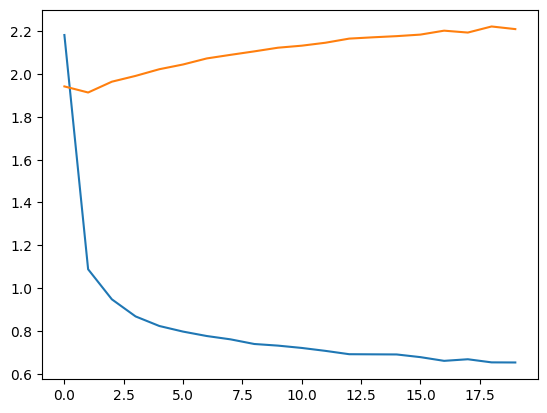

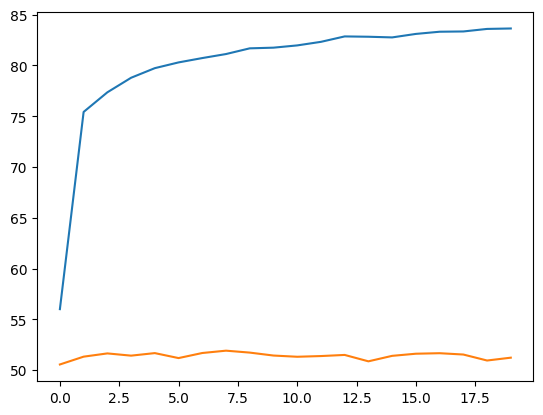

In [ ]:
lr = 1e-4 # Hparam to complete
batch_size = 128 # Hparam to complete

supervised_training(simclr_model=simclr_model, device=device, n_classes=100, n_epochs=20, lr=lr, batch_size=batch_size)